In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import json
import os

# Label mappings
modality_map = {"01": "full-AV", "02": "video-only", "03": "audio-only"}
channel_map = {"01": "speech", "02": "song"}
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
intensity_map = {"01": "normal", "02": "strong"}
statement_map = {"01": "kids", "02": "dogs"}
repetition_map = {"01": "1st", "02": "2nd"}


base_dirs = ["/content/drive/MyDrive/Song", "/content/drive/MyDrive/Speech"]

metadata = {}

def process_directory(base_dir):
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".wav"):
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, base_dir)

                parts = file.replace(".wav", "").split("-")
                if len(parts) != 7:
                    print(f"⚠️ Skipping malformed file: {file}")
                    continue

                modality = modality_map.get(parts[0], "unknown")
                channel = channel_map.get(parts[1], "unknown")
                emotion = emotion_map.get(parts[2], "unknown")
                intensity = intensity_map.get(parts[3], "unknown")
                statement = statement_map.get(parts[4], "unknown")
                repetition = repetition_map.get(parts[5], "unknown")
                actor_id = int(parts[6])
                gender = "male" if actor_id % 2 == 1 else "female"

                metadata[file] = {
                    "relative_path": os.path.join(base_dir, rel_path),
                    "modality": modality,
                    "channel": channel,
                    "emotion": emotion,
                    "intensity": intensity,
                    "statement": statement,
                    "repetition": repetition,
                    "actor_id": actor_id,
                    "gender": gender
                }

# Run on both folders
for base_dir in base_dirs:
    if os.path.exists(base_dir):
        print(f"✅ Processing: {base_dir}")
        process_directory(base_dir)
    else:
        print(f"❌ Directory not found: {base_dir}")

# Save to metadata.json
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n🎉 Done! Metadata for {len(metadata)} files written to 'metadata.json'")


✅ Processing: /content/drive/MyDrive/Song
✅ Processing: /content/drive/MyDrive/Speech

🎉 Done! Metadata for 2452 files written to 'metadata.json'


In [3]:
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Load metadata
with open("metadata.json") as f:
    metadata = json.load(f)

# Label mapping
emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
label2idx = {label: i for i, label in enumerate(emotion_list)}
idx2label = {i: label for label, i in label2idx.items()}



SAMPLE_RATE = 32000
MAX_LEN = 5
N_MELS = 128




def extract_melspec(path, max_len=5, sr=16000, n_mels=128):
    y, _ = librosa.load(path, sr=sr)
    y = librosa.util.fix_length(y, size=int(sr * max_len))
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    melspec_db = (melspec_db - melspec_db.mean()) / (melspec_db.std() + 1e-6)
    return melspec_db.astype(np.float32)




# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, metadata, base_dir):
        self.samples = []
        for fname, meta in metadata.items():
            path = os.path.join(base_dir, meta["relative_path"])
            if os.path.exists(path):
                self.samples.append((path, label2idx[meta["emotion"]]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        features = extract_melspec(path)
        return torch.tensor(features).unsqueeze(0), torch.tensor(label)

In [ ]:
from collections import Counter
Counter(meta["emotion"] for meta in metadata.values())


Counter({'calm': 376,
         'angry': 376,
         'neutral': 188,
         'sad': 376,
         'happy': 376,
         'fearful': 376,
         'surprised': 192,
         'disgust': 192})

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16LSTM(nn.Module):
    def __init__(self, num_classes, fine_tune=True):
        super().__init__()


        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)

        self.feature_extractor = vgg.features


        if not fine_tune:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        self.lstm_input_size = 512 * 4


        self.lstm1 = nn.LSTM(input_size=self.lstm_input_size, hidden_size=160, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(320)
        self.dropout1 = nn.Dropout(0.3)

        self.lstm2 = nn.LSTM(input_size=320, hidden_size=160, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(320)
        self.dropout2 = nn.Dropout(0.3)

        self.final_dropout = nn.Dropout(0.1)


        self.fc = nn.Sequential(
            nn.Linear(320, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.permute(0, 3, 1, 2)
        B, T, C, H = x.size()
        x = x.reshape(B, T, C * H)

        x, _ = self.lstm1(x)
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.bn2(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout2(x)

        x = torch.max(x, dim=1).values
        x = self.final_dropout(x)
        return self.fc(x)






In [7]:
# Split data: 80% for training, 20% for validation
all_files = list(metadata.items())
train_data, val_data = train_test_split(
    all_files,
    test_size=0.2,
    random_state=42,
    stratify=[m['emotion'] for _, m in all_files]
)

# Construct metadata dictionaries
train_meta = {k: v for k, v in train_data}
val_meta   = {k: v for k, v in val_data}

train_ds = EmotionDataset(train_meta, base_dir="Speech")
val_ds   = EmotionDataset(val_meta, base_dir="Speech")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)


In [8]:
# Training
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = [label2idx[m["emotion"]] for m in metadata.values()]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
model = VGG16LSTM(num_classes=8, fine_tune=True).to(device)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.9MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:

for epoch in range(30):
    model.train()
    total_loss = 0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss:.2f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            preds = model(X).argmax(1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(y.numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f"Validation Accuracy: {val_acc:.2%}, F1 Score: {val_f1:.2%}")
    scheduler.step(val_acc)


Epoch 1: 100%|██████████| 123/123 [22:35<00:00, 11.02s/it]


Train Loss: 252.67
Validation Accuracy: 26.68%, F1 Score: 23.70%


Epoch 2: 100%|██████████| 123/123 [00:47<00:00,  2.58it/s]


Train Loss: 244.01
Validation Accuracy: 33.81%, F1 Score: 27.66%


Epoch 3: 100%|██████████| 123/123 [00:47<00:00,  2.57it/s]


Train Loss: 233.18
Validation Accuracy: 39.31%, F1 Score: 31.96%


Epoch 4: 100%|██████████| 123/123 [00:49<00:00,  2.46it/s]


Train Loss: 217.69
Validation Accuracy: 48.47%, F1 Score: 43.28%


Epoch 5: 100%|██████████| 123/123 [00:49<00:00,  2.47it/s]


Train Loss: 200.16
Validation Accuracy: 47.25%, F1 Score: 42.45%


Epoch 6: 100%|██████████| 123/123 [00:47<00:00,  2.57it/s]


Train Loss: 184.96
Validation Accuracy: 54.79%, F1 Score: 50.35%


Epoch 7: 100%|██████████| 123/123 [00:51<00:00,  2.38it/s]


Train Loss: 169.67
Validation Accuracy: 59.47%, F1 Score: 56.56%


Epoch 8: 100%|██████████| 123/123 [00:49<00:00,  2.48it/s]


Train Loss: 151.82
Validation Accuracy: 63.14%, F1 Score: 61.24%


Epoch 9: 100%|██████████| 123/123 [00:47<00:00,  2.60it/s]


Train Loss: 137.70
Validation Accuracy: 65.99%, F1 Score: 63.62%


Epoch 10: 100%|██████████| 123/123 [00:47<00:00,  2.57it/s]


Train Loss: 122.26
Validation Accuracy: 72.71%, F1 Score: 72.09%


Epoch 11: 100%|██████████| 123/123 [00:49<00:00,  2.47it/s]


Train Loss: 108.16
Validation Accuracy: 72.51%, F1 Score: 71.41%


Epoch 12: 100%|██████████| 123/123 [00:49<00:00,  2.49it/s]


Train Loss: 96.82
Validation Accuracy: 73.73%, F1 Score: 73.71%


Epoch 13: 100%|██████████| 123/123 [00:47<00:00,  2.57it/s]


Train Loss: 89.20
Validation Accuracy: 77.60%, F1 Score: 77.30%


Epoch 14: 100%|██████████| 123/123 [00:49<00:00,  2.46it/s]


Train Loss: 80.61
Validation Accuracy: 77.80%, F1 Score: 77.47%


Epoch 15: 100%|██████████| 123/123 [00:50<00:00,  2.44it/s]


Train Loss: 75.52
Validation Accuracy: 76.17%, F1 Score: 76.11%


Epoch 16: 100%|██████████| 123/123 [00:47<00:00,  2.58it/s]


Train Loss: 73.10
Validation Accuracy: 76.78%, F1 Score: 76.32%


Epoch 17: 100%|██████████| 123/123 [00:48<00:00,  2.56it/s]


Train Loss: 71.47
Validation Accuracy: 76.78%, F1 Score: 76.54%


Epoch 18: 100%|██████████| 123/123 [00:49<00:00,  2.48it/s]


Train Loss: 67.77
Validation Accuracy: 81.87%, F1 Score: 81.81%


Epoch 19: 100%|██████████| 123/123 [00:48<00:00,  2.56it/s]


Train Loss: 65.46
Validation Accuracy: 82.89%, F1 Score: 82.71%


Epoch 20: 100%|██████████| 123/123 [00:47<00:00,  2.60it/s]


Train Loss: 65.28
Validation Accuracy: 81.26%, F1 Score: 80.91%


Epoch 21: 100%|██████████| 123/123 [00:47<00:00,  2.59it/s]


Train Loss: 64.57
Validation Accuracy: 81.06%, F1 Score: 80.88%


Epoch 22: 100%|██████████| 123/123 [00:49<00:00,  2.48it/s]


Train Loss: 64.95
Validation Accuracy: 84.93%, F1 Score: 85.03%


Epoch 23: 100%|██████████| 123/123 [00:49<00:00,  2.48it/s]


Train Loss: 63.76
Validation Accuracy: 83.91%, F1 Score: 83.85%


Epoch 24: 100%|██████████| 123/123 [00:47<00:00,  2.56it/s]


Train Loss: 64.06
Validation Accuracy: 81.67%, F1 Score: 81.56%


Epoch 25: 100%|██████████| 123/123 [00:47<00:00,  2.59it/s]


Train Loss: 63.82
Validation Accuracy: 83.71%, F1 Score: 83.56%


Epoch 26: 100%|██████████| 123/123 [00:48<00:00,  2.51it/s]


Train Loss: 62.83
Validation Accuracy: 83.50%, F1 Score: 83.38%


Epoch 27: 100%|██████████| 123/123 [00:49<00:00,  2.48it/s]


Train Loss: 62.66
Validation Accuracy: 83.91%, F1 Score: 83.88%


Epoch 28: 100%|██████████| 123/123 [00:47<00:00,  2.60it/s]


Train Loss: 62.38
Validation Accuracy: 85.95%, F1 Score: 85.80%


Epoch 29: 100%|██████████| 123/123 [00:47<00:00,  2.61it/s]


Train Loss: 61.99
Validation Accuracy: 85.54%, F1 Score: 85.38%


Epoch 30: 100%|██████████| 123/123 [00:50<00:00,  2.44it/s]


Train Loss: 62.42
Validation Accuracy: 82.69%, F1 Score: 82.61%


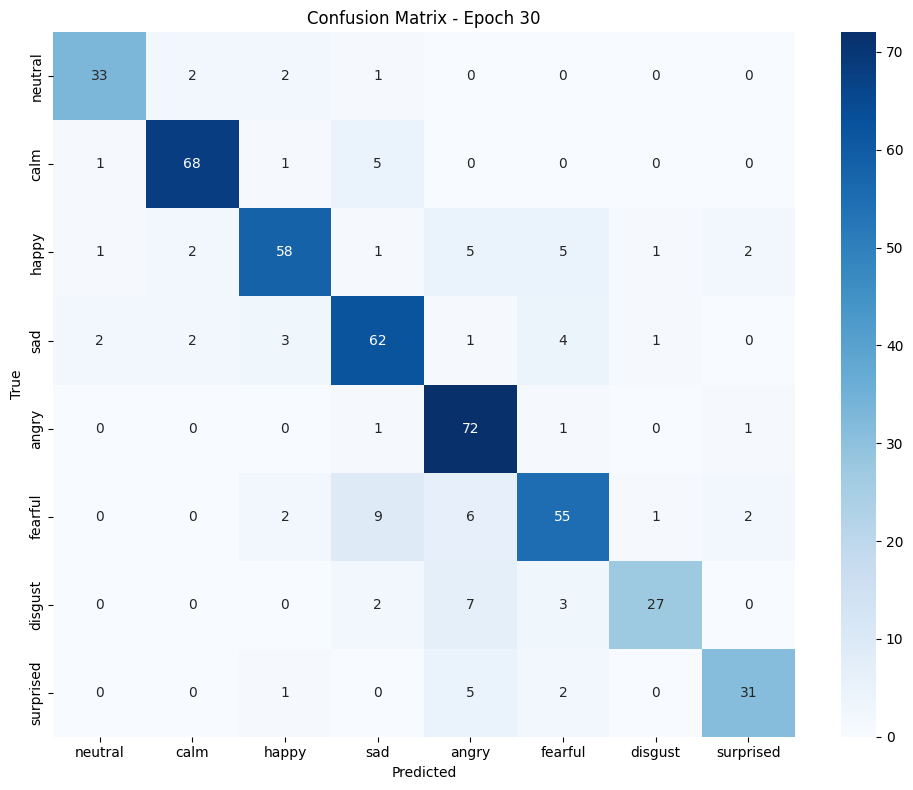

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

idx2label = {v: k for k, v in label2idx.items()}

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx2label[i] for i in range(len(idx2label))],
            yticklabels=[idx2label[i] for i in range(len(idx2label))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Epoch {epoch+1}')
plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(),"emotion_model.pth")